## Project 1 - Predicting Bike Rental Patterns

Using historical data surrounding bike rental patterns, the neural network will attempt to predict bike rental volumes at different times during the year.

In [1]:
# Import libs
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load in raw data
data_path = './NeuralNet1/Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

In [3]:
# Explore data a bit
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days in the data set. You can see the hourly rentals here.

The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders.

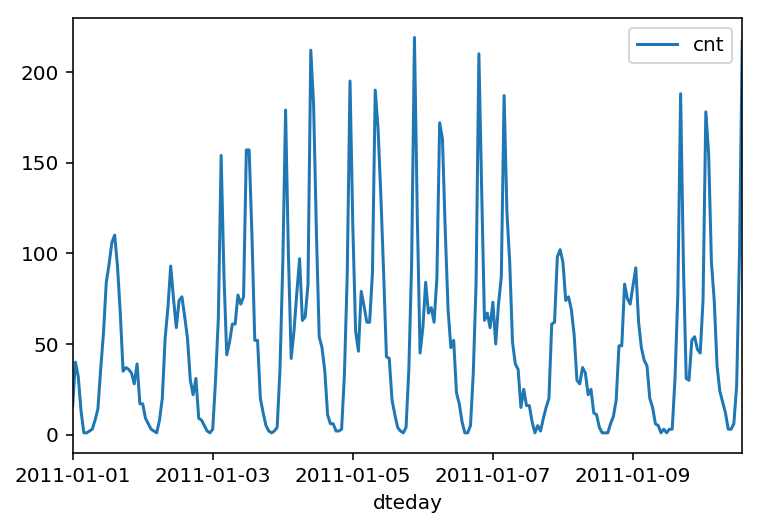

In [4]:
# Graph of rental riders
rides[:24*10].plot(x='dteday', y='cnt')

In [15]:
# Creating dummy binary variables to include categorical data 
# such as: season, weather, or month
# Essentially just converting fields like Season = 1,2,3 or 4
# to each have a binary field of their own 1 or 0

dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


## Scaling Target Variables

To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.
The scaling factors are saved so we can go backwards when we use the network for predictions.



In [12]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Store Scalings in a dict so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

/home/gavin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Splitting the data into training, test, and validation sets

Save the last 21 days of data for use as test set after network is trained. 

In [14]:
# Save last 21 days
test_data = data[-21*24:]
data = data[:-21*24]

# Seperate data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features = data.drop(target_fields, axis=1)
targets = data[target_fields]
test_features = test_data.drop(target_fields, axis=1)
test_targets = test_data[target_fields]

In [16]:
# Hold out the last 60 days of the remaining data as a validation set
train_features = features[:-60*24]
train_targets = targets[:-60*24]
val_features = features[-60*24:]
val_targets = targets[-60*24:]

## Building the network


In [22]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set num of nodes in each layer
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        # Initialize Weights
        self.weights_input_to_hidden = np.random.normal(0.0,
                                                       self.hidden_nodes**-0.5,
                                                       (self.hidden_nodes, self.input_nodes))
        
        self.weights_hidden_to_output = np.random.normal(0.0,
                                                        self.output_nodes**-0.5,
                                                        (self.output_nodes, self.hidden_nodes))
        # Learning Rate
        self.lr = learning_rate
        
        # Sigmoid acitivation function
        self.activation_function = lambda x: 1/(1+np.exp(-x))
        
    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        # Forward pass
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        
        # Backward pass
        output_errors = np.subtract(targets, final_outputs)
        hidden_errors = np.dot(self.weights_hidden_to_output.T,
                              output_errors)
        hidden_grad = hidden_outputs * (1 - hidden_outputs)
        
        
        
        # Weight updates
        self.weights_hidden_to_output += self.lr * np.dot(output_errors,
                                                         hidden_outputs.T)
        
        self.weights_input_to_hidden += self.lr *np.dot((hidden_grad * hidden_errors),
                                                       inputs.T)
        
    def run(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T
        
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        
        return final_outputs
        

In [23]:
# Mean standard error function
def MSE(y, Y):
    return np.mean((y-Y)**2)


## Training the network

In [26]:
import sys

# Set hyper parameters
epochs = 1200
learning_rate = 0.1 
hidden_nodes = 25
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values,
                             train_targets.ix[batch]['cnt']):
        network.train(record, target)
        
    # Print training progress
    train_loss = MSE(network.run(train_features),
                    train_targets['cnt'].values)
    
    val_loss = MSE(network.run(val_features),
                  val_targets['cnt'].values)
    
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)
    

Progress: 99.9% ... Training loss: 0.048 ... Validation loss: 0.150

(-0.025781687523779288, 0.5)

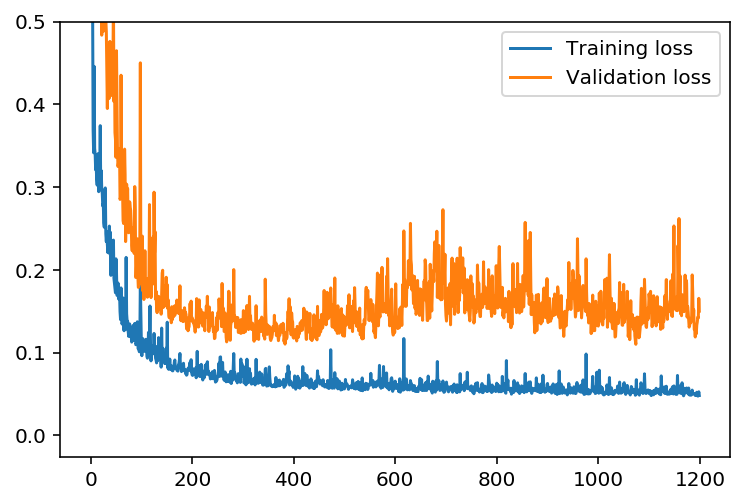

In [27]:
# Network Performance
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=0.5)

/home/gavin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


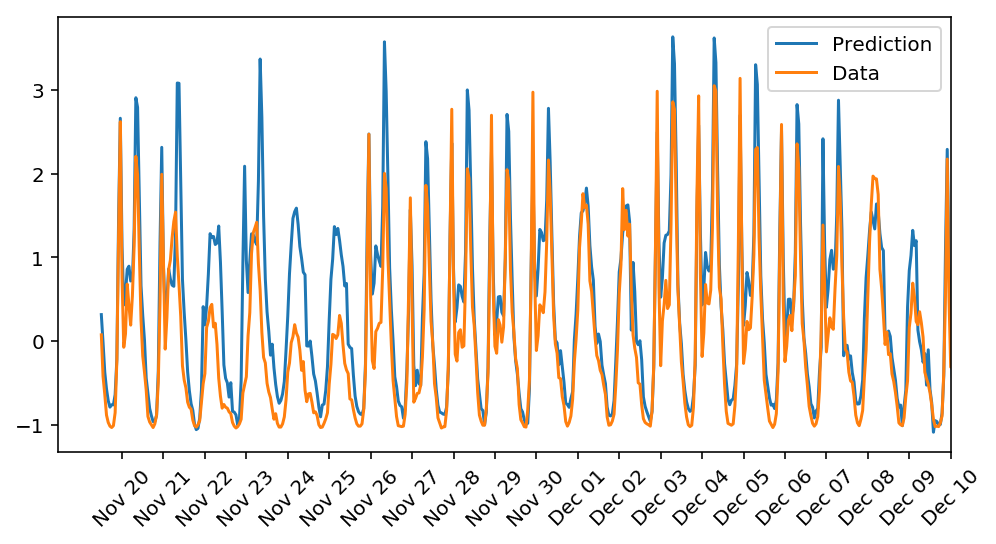

In [28]:
# Check results of model predictions vs actual
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)